In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
dir3 = dir1+'/spike_tools'
if not dir1 in sys.path: sys.path.append(dir1)
if not dir3 in sys.path: sys.path.append(dir3)

from spike_tools.utils.spikeutils import remove_artefacts, remove_artefacts_mod, remove_artefacts_feng, remove_artefacts_reverse

Loading lookup from /om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/brainio_collection/lookup.csv


/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/brainscore/metrics/__init__.py:37: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [3]:
import numpy as np
import joblib
import scipy.io as sio
import pandas as pd

import xarray
import matplotlib.pyplot as plt
import seaborn as sns

import logging

from pathlib import Path

from sklearn.linear_model import LinearRegression
# from brainscore.metrics.regression import pearsonr
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import os


from brainio_base.assemblies import NeuronRecordingAssembly
import brainscore

from utils.intanutils import read_amplifier
from utils.filter import bandpass_filter, notch_filter
from utils import find_nearest


from scipy import signal, interpolate
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.fft import fft, fftfreq


import configparser


config = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
config.read('../spike_tools/spike_config.ini')

['../spike_tools/spike_config.ini']

# Prepare Data

In [4]:
config['Experiment Information']['name'] = 'stimulation-with-control'
date = '211001'


dataPath = "/braintree/data2/active/users/ssazaidi/projects/"+config['Experiment Information']['name']+"/monkeys/oleo/"
procDataPath = dataPath+'intanproc'
rawDataPath =  dataPath+'intanraw'

### Load MWORKS DATA ###

mworksDirproc = '../../projects/'+config['Experiment Information']['name']+'/monkeys/oleo/mworksproc/'
mworksFilename = [i for i in os.listdir(mworksDirproc) if date in i][0]
data_info = pd.read_csv(os.path.join(mworksDirproc, mworksFilename))
samp_on_id = data_info.stim_id.values
samp_on_current = data_info.stim_current.values

In [37]:
### Define necessary paths ###

artefact_times_path = os.path.join(rawDataPath, date, 'artefact_time_'+date+'.pkl')
samp_filename = os.path.join(rawDataPath,date,'samp_time_'+date+'.pkl')
mworksproc_name = os.path.join(dataPath, 'mworksproc', [i for i in os.listdir(dataPath+'mworksproc') if date in i][0] )   

# mworksDirproc = os.path.join(os.path.dirname(raw_dir), 'mworksproc')
# mworksFilename = [i for i in os.listdir(mworksDirproc) if date in i][0]
# data_info = pd.read_csv(os.path.join(mworksDirproc, mworksFilename))
# samp_on_id = data_info.stim_id.values
# samp_on_current = data_info.stim_current.values

In [6]:
### Create Channel List ###
channel_letters = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
channel_numbers = np.arange(32)


all_channels = np.array(np.meshgrid( channel_numbers, channel_letters))
all_channels = np.core.defchararray.add(np.core.defchararray.add(all_channels[1],'-'),np.char.zfill(all_channels[0], 3))
all_channels = all_channels.flatten()

n_channels = len(all_channels)



In [7]:
### Set variables ###
recording_channel = 'C-024'
samplingFrequency = 20000
f_low = 300
f_high = 5000

num_pulses=10
pulse_width_usec=4000

channel_num = np.where(all_channels == recording_channel.lower())[0][0]

## Load Data

In [8]:
if os.path.exists(samp_filename):
    samp_on = joblib.load(samp_filename)
else:
    filename = Path(os.path.join(directory_path, 'board-DIGITAL-IN-02.dat'))
    fid = open(filename, 'r')
    filesize = os.path.getsize(filename) # in bytes
    num_samples = filesize // 2 # uint16 = 2 bytes
    din02 = np.fromfile(fid, 'uint16', num_samples)
    fid.close()

    samp_on, = np.nonzero(din02[:-1] < din02[1:]) # Look for 0->1 transitions
    samp_on = samp_on + 1 # Previous line returns indexes of 0s seen before spikes, but we want indexes of first spikes
    joblib.dump(samp_on, samp_filename)


data_info = pd.read_csv(mworksproc_name)
samp_on_id = data_info.stim_id.values
samp_on_current = data_info.stim_current.values


artefact_times = joblib.load(artefact_times_path)
nan_sums = np.sum(np.isnan(artefact_times), axis=0)
good_ones = np.where(nan_sums < 96)[0]

artefact_times = np.nanmedian(artefact_times, axis=0).astype(int)
artefact_times = artefact_times[good_ones]


/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [9]:
# Get names of all directories with the specified 'date'.
with os.scandir(rawDataPath) as it:
    dirs = [entry.name for entry in it if (entry.is_dir() and entry.name.find(date) != -1 and entry.name != date)]
dirs.sort()

d = dirs[0]
# Get all raw neural data files
with os.scandir(os.path.join(rawDataPath, d)) as it:
    files = [entry.name for entry in it if (entry.is_file() and entry.name.find('amp') != -1)]
files.sort()  # The files are randomly loaded, so sort them
print(n_channels, len(files))
assert len(files) == n_channels  # Check if number of files matches number of channels


v = read_amplifier(os.path.join(rawDataPath, d, files[channel_num]))  # In microvolts

192 192


In [10]:
# v = notch_filter(v, f_sampling=samplingFrequency, f_notch=60, bandwidth=10)
    

## Remove Artefacts

In [11]:
len(samp_on_current), len(artefact_times), len(good_ones)

(6500, 6500, 6500)

In [12]:
art_num = 25

In [14]:
v1 = remove_artefacts_mod(v, artefact_times[:100], samplingFrequency, f_low, f_high, art_time_usec=900, 
                     v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=False, samp_current=samp_on_current);


# v2 = remove_artefacts(v, artefact_times[:100], samplingFrequency, f_low, f_high, art_time_usec=900, 
#                      v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=True);

v2 = remove_artefacts_mod(v, artefact_times[:100], samplingFrequency, f_low, f_high, art_time_usec=900, 
                     v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=True, samp_current=samp_on_current);

# v2, y_out = remove_artefacts_feng(v, artefact_times[:100], samplingFrequency, f_low, f_high, art_time_usec=900, 
#                      v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=True, return_curve = art_num);

# v2 = remove_artefacts_reverse(v, artefact_times[:100], samplingFrequency, f_low, f_high, art_time_usec=900, 
#                      v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=True);

pulse_width is:  81
4
pulse_width is:  81
4


In [15]:
# v_band_passed1 = bandpass_filter(v1, samplingFrequency, f_low, f_high)
# v_band_passed1 = v_band_passed1 - np.nanmean(v_band_passed1)

# v_band_passed2 = bandpass_filter(v2, samplingFrequency, f_low, f_high)
# v_band_passed2 = v_band_passed2 - np.nanmean(v_band_passed2)

### Roelfsema Plots

## Combined Figure

In [ ]:
art_num = 20

color_ = 'g'


width=0.3
height= 0.1
pad_ratio_x = 0.2
pad_ratio_y = 0.5

########### FIGURE ###############
fig = plt.figure(figsize=[15,20])



#################### BROADBAND SIGNAL A ############
row = 0
column= 0
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height
ax = fig.add_axes([left,bottom, width,height])

pre_ = 2000
post_ = 4000


broadband_signal = v[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]

t= 1000* np.arange(-pre_, post_) /samplingFrequency


plt.plot(t, broadband_signal, color_)
plt.title('Broadband signal, '+str(samp_on_id[art_num])+', '+ str(samp_on_current[art_num]))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')
# plt.show()
# plt.close()




################################### ARTEFACT REMOVED B #######################


row = 0
column= 1
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height
ax = fig.add_axes([left,bottom, width,height])


broadband_signal_artefact_removed = v1[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_artefact_removed, color_)
plt.title('Artefact removed')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')

######################### SALPA APPLIED C ###############################
row = 0
column= 2
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height

ax = fig.add_axes([left,bottom, width,height])
broadband_signal_salpa = v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
# print( v2[artefact_times[art_num]:artefact_times[art_num]+post_])
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_salpa, color_)
plt.title('After Salpa')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')



################################## AVERAGE ARTEFACT D ##################################

row = 1
column= 0
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height
axes1 = fig.add_axes([left,bottom, width,height])


pre_ = 3
post_ = 50
pulse_length = 81

sample_time = artefact_times
print(art_num)
average_raw_artefact = np.zeros((post_+pre_))
average_after_interpolation = np.zeros((post_+pre_))
average_after_salpa = np.zeros((post_+pre_))


for pulse in np.arange(num_pulses):
    average_raw_artefact += (v[sample_time[art_num]-pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
    average_after_interpolation += (v1[sample_time[art_num]-pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
    average_after_salpa += (v2[sample_time[art_num]-pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])

average_raw_artefact /= num_pulses
average_after_interpolation /= num_pulses
average_after_salpa /= num_pulses


t_ = np.arange(-pre_,post_)*1000/samplingFrequency






axes1.plot(t_,average_raw_artefact, 'b', alpha=1 , label ='Avg raw artefact')
axes1.plot(t_,average_after_interpolation, 'r', alpha=1, label ='Avg after interpolation')
axes1.plot(t_,average_after_salpa, 'y', alpha=1, label ='Avg after SALPA')
plt.legend()

axes1.set_title('Average traces')
axes1.set_xlabel('time (ms)')
axes1.set_ylabel('Voltage (uV)')



axes = fig.add_axes([left + 0.55*width,bottom +  0.1*height,width*0.4,height*0.4])
axes.plot(t_,average_after_interpolation, 'r', alpha=1)
axes.plot(t_,average_after_salpa, 'y-.', alpha=1)

################################## EXAMPLE ARTEFACT E ########################

row = 1
column= 1
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height

ax = fig.add_axes([left,bottom, width,height])

pre_ = 2500 
post_= 4500
sample_broadband_signal = v[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
art_removed_signal = v1[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
y_out = (v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_])

pulse_num = 2


start_ = 0
end_ = 80
sub_broadband_signal = sample_broadband_signal[pre_+(pulse_num-1)*pulse_length - start_ : pre_+(pulse_num-1)*pulse_length+ end_]
sub_art_removed_signal = art_removed_signal[pre_+(pulse_num-1)*pulse_length - start_ : pre_+(pulse_num-1)*pulse_length+ end_]
sub_y_out =            y_out           [pre_+(pulse_num-1)*pulse_length - start_ : pre_+(pulse_num-1)*pulse_length+ end_]

t= 1000* np.arange(-start_, end_) /samplingFrequency

plt.plot(t,sub_art_removed_signal , 'b', label='Example Artefact')
# plt.plot(sub_broadband_signal , 'k')
plt.plot(t,sub_y_out, 'y', label = 'Difference')

fitted_curve = sub_art_removed_signal - sub_y_out
fitted_curve[:21] = np.nan

plt.plot(t, fitted_curve , 'r', label='Curve fitting (SALPA)')

plt.legend()

plt.title('After Salpa')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')


################################################### FREQUENCY F ###############################

row = 1
column= 2
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height

ax = fig.add_axes([left,bottom, width,height])

pre_ = 2000
post_ = 400


start_freq = 0
freq_frac = 8

N = pre_+post_
# sample spacing
T = 1.0 / samplingFrequency
x = np.linspace(0.0, N*T, N, endpoint=False)
y = broadband_signal
yf_broadband = fft(broadband_signal)
yf_artefact_removed = fft(broadband_signal_artefact_removed)
yf_salpa = fft(broadband_signal_salpa)
xf = fftfreq(N, T)[:N//2][start_freq:N//freq_frac]
import matplotlib.pyplot as plt
# plt.subplot(1,3,1)
plt.plot(xf,10*np.log10( 2.0/N * np.abs(yf_broadband[0:N//2])[start_freq:N//freq_frac]), 'b-', label='Before Salpa')
# plt.subplot(1,3,2)
plt.plot(xf,10*np.log10( 2.0/N * np.abs(yf_artefact_removed[0:N//2])[start_freq:N//freq_frac]), 'g-', label = 'After Artefact Removal')
# plt.subplot(1,3,1)
plt.plot(xf,10*np.log10( 2.0/N * np.abs(yf_salpa[0:N//2])[start_freq:N//freq_frac]), 'r-', label = 'After Salpa')
# tick_val = plt.yticks();
# plt.yticks(tick_val[0], np.power(tick_val[0], 10))

plt.legend()

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB/Hz)')



########################################  BANDPASS RECTIFICATION G ################################
row = 2
column= 0
left = 0 + (column)*(1+pad_ratio_x)*width
bottom = 1 - (row+1)*(1+pad_ratio_y)*height

ax = fig.add_axes([left,bottom, width,height])



pre_ = 1000
post_ = 1500


f_low = 1000
f_high = 5000
broadband_signal_bandpass_rectification = np.maximum(0, bandpass_filter(v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_], samplingFrequency, f_low, f_high))
# broadband_signal_salpa = v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
# print( v2[artefact_times[art_num]:artefact_times[art_num]+post_])
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_bandpass_rectification, color_)
plt.title('BandPass Rectificaiton')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')


################################# LOW PASS MUA H ######################################

row = 2
column= 1
left = 0 + (column) * (1+pad_ratio_x) *width
bottom = 1 - (row+1)* (1+pad_ratio_y) *height
ax = fig.add_axes([left,bottom, width,height])


f_low = 0.1
f_high = 200
broadband_signal_low_pass = bandpass_filter(broadband_signal_bandpass_rectification, samplingFrequency, f_low, f_high)
# broadband_signal_salpa = v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
# print( v2[artefact_times[art_num]:artefact_times[art_num]+post_])
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_low_pass, color_)
plt.title('Low Pass')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')

plt.suptitle(' '.join(['Recording Site', all_channels[channel_num].capitalize(), ';','Stimulation Site', samp_on_id[art_num].capitalize()]))

plt.savefig('_'.join(['Figures/Combined_Plots','rec_site', all_channels[channel_num],'stim_site', samp_on_id[art_num]]), bbox_inches='tight')
plt.show()
plt.close()

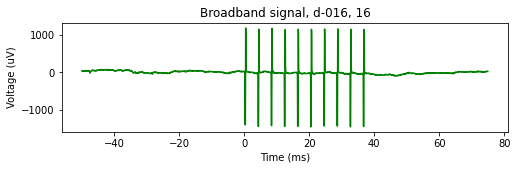

In [23]:
art_num = 24

color_ = 'g'

### Take raw Signal v ###
v.shape

### Take an instance of the artefacts and plot it

 ## Artefact number
pre_ = 1000
post_ = 1500


broadband_signal = v[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
fig = plt.figure(figsize=[8,2])
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal, color_)
plt.title('Broadband signal, '+str(samp_on_id[art_num])+', '+ str(samp_on_current[art_num]))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')
plt.show()
plt.close()

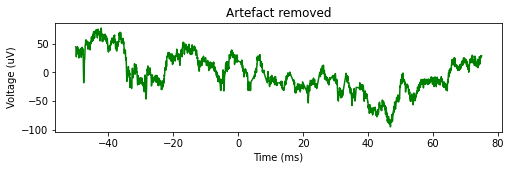

In [24]:
### Chop out the artefact ###

# v1 = remove_artefacts(v, artefact_times, samplingFrequency, f_low, f_high, art_time_usec=1200, 
#                      v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=False)




broadband_signal_artefact_removed = v1[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
fig = plt.figure(figsize=[8,2])
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_artefact_removed, color_)
plt.title('Artefact removed')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')
plt.show()
plt.close()

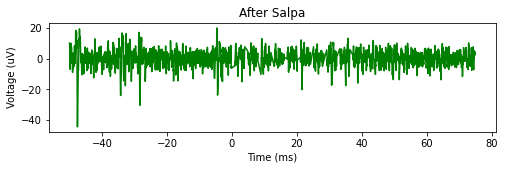

In [25]:
### Chop out the artefact and apply salpa ###

# v2 = remove_artefacts(v, artefact_times, samplingFrequency, f_low, f_high, art_time_usec=1200, 
#                      v_thres=400, num_pulses=10, pulse_width_usec=4000, apply_salpa=True)




# broadband_signal_salpa = bandpass_filter(v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_], samplingFrequency, f_low, f_high)
broadband_signal_salpa = v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
# print( v2[artefact_times[art_num]:artefact_times[art_num]+post_])
fig = plt.figure(figsize=[8,2])
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_salpa, color_)
plt.title('After Salpa')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')
plt.show()
plt.close()

24


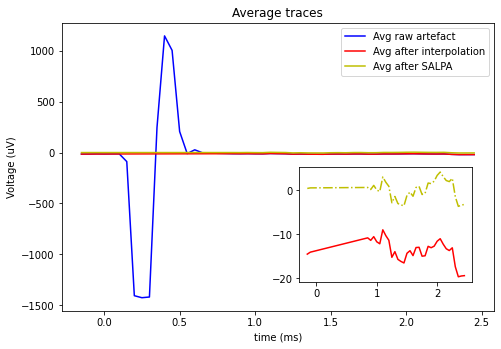

In [30]:
pre_ = 3
post_ = 50
pulse_length = 81

sample_time = artefact_times
print(art_num)
average_raw_artefact = np.zeros((post_+pre_))
average_after_interpolation = np.zeros((post_+pre_))
average_after_salpa = np.zeros((post_+pre_))


for pulse in np.arange(num_pulses):
    average_raw_artefact += (v[sample_time[art_num]-pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
    average_after_interpolation += (v1[sample_time[art_num]-pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
    average_after_salpa += (v2[sample_time[art_num]-pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])

average_raw_artefact /= num_pulses
average_after_interpolation /= num_pulses
average_after_salpa /= num_pulses


t_ = np.arange(-pre_,post_)*1000/samplingFrequency


fig = plt.figure()

axes1 = fig.add_axes([0, 0, 1, 1])
axes1.plot(t_,average_raw_artefact, 'b', alpha=1 , label ='Avg raw artefact')
axes1.plot(t_,average_after_interpolation, 'r', alpha=1, label ='Avg after interpolation')
axes1.plot(t_,average_after_salpa, 'y', alpha=1, label ='Avg after SALPA')
plt.legend()

axes1.set_title('Average traces')
axes1.set_xlabel('time (ms)')
axes1.set_ylabel('Voltage (uV)')



axes = fig.add_axes([0.55, 0.1, 0.4, 0.4])
axes.plot(t_,average_after_interpolation, 'r', alpha=1)
axes.plot(t_,average_after_salpa, 'y-.', alpha=1)


plt.show()
plt.close()


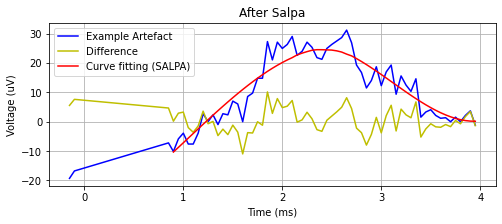

In [31]:
### Chop out the artefact and apply salpa ###
pre_ = 2500 
post_= 4500
sample_broadband_signal = v[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
art_removed_signal = v1[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
y_out = (v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_])

pulse_num = 2


start_ = 3
end_ = 80
sub_broadband_signal = sample_broadband_signal[pre_+(pulse_num-1)*pulse_length - start_ : pre_+(pulse_num-1)*pulse_length+ end_]
sub_art_removed_signal = art_removed_signal[pre_+(pulse_num-1)*pulse_length - start_ : pre_+(pulse_num-1)*pulse_length+ end_]
sub_y_out =            y_out           [pre_+(pulse_num-1)*pulse_length - start_ : pre_+(pulse_num-1)*pulse_length+ end_]

fig = plt.figure(figsize=[8,3])
t= 1000* np.arange(-start_, end_) /samplingFrequency

plt.plot(t,sub_art_removed_signal , 'b', label='Example Artefact')
# plt.plot(sub_broadband_signal , 'k')
plt.plot(t,sub_y_out, 'y', label = 'Difference')

fitted_curve = sub_art_removed_signal - sub_y_out
fitted_curve[:21] = np.nan

plt.plot(t, fitted_curve , 'r', label='Curve fitting (SALPA)')

plt.legend()

plt.title('After Salpa')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')
plt.grid(True)
plt.show()
plt.close()

In [32]:
pre_, post_

(2500, 4500)

### Frequency

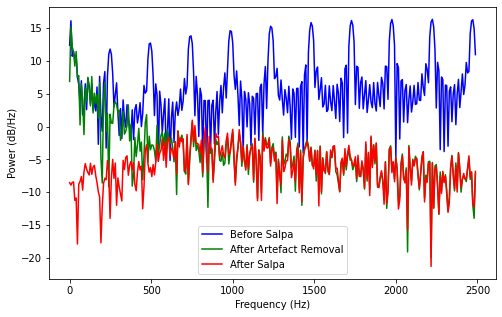

In [33]:

# Number of sample points

pre_ = 1000
post_ = 1500


start_freq = 0
freq_frac = 8

N = pre_+post_
# sample spacing
T = 1.0 / samplingFrequency
x = np.linspace(0.0, N*T, N, endpoint=False)
y = broadband_signal
yf_broadband = fft(broadband_signal)
yf_artefact_removed = fft(broadband_signal_artefact_removed)
yf_salpa = fft(broadband_signal_salpa)
xf = fftfreq(N, T)[:N//2][start_freq:N//freq_frac]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[8,5])
# plt.subplot(1,3,1)
plt.plot(xf,10*np.log10( 2.0/N * np.abs(yf_broadband[0:N//2])[start_freq:N//freq_frac]), 'b-', label='Before Salpa')
# plt.subplot(1,3,2)
plt.plot(xf,10*np.log10( 2.0/N * np.abs(yf_artefact_removed[0:N//2])[start_freq:N//freq_frac]), 'g-', label = 'After Artefact Removal')
# plt.subplot(1,3,1)
plt.plot(xf,10*np.log10( 2.0/N * np.abs(yf_salpa[0:N//2])[start_freq:N//freq_frac]), 'r-', label = 'After Salpa')
# tick_val = plt.yticks();
# plt.yticks(tick_val[0], np.power(tick_val[0], 10))

plt.legend()

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB/Hz)')

plt.show()

plt.close()

### Bandpass Rectification

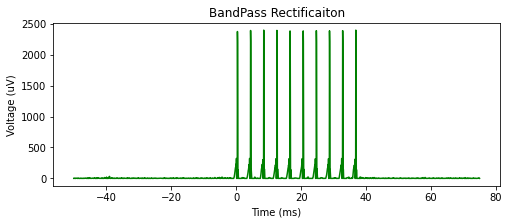

In [45]:
pre_ = 1000
post_ = 1500


f_low = 1000
f_high = 5000
broadband_signal_bandpass_rectification = np.maximum(0, bandpass_filter(v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_], samplingFrequency, f_low, f_high))
# broadband_signal_salpa = v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
# print( v2[artefact_times[art_num]:artefact_times[art_num]+post_])
fig = plt.figure(figsize=[8,3])
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_bandpass_rectification, color_)
plt.title('BandPass Rectificaiton')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')
plt.show()
plt.close()

### Low-pass MUA

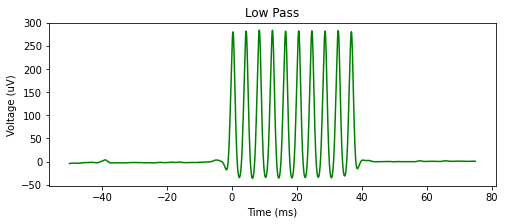

In [46]:
f_low = 1
f_high = 200
broadband_signal_low_pass = bandpass_filter(broadband_signal_bandpass_rectification, samplingFrequency, f_low, f_high)
# broadband_signal_salpa = v2[artefact_times[art_num]-pre_:artefact_times[art_num]+post_]
# print( v2[artefact_times[art_num]:artefact_times[art_num]+post_])
fig = plt.figure(figsize=[8,3])
t= 1000* np.arange(-pre_, post_) /samplingFrequency
plt.plot(t, broadband_signal_low_pass, color_)
plt.title('Low Pass')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')
plt.show()
plt.close()

## Separate samples

In [ ]:
# ### Visualize Average Post-artefact Power ###

# pre_ = -30
# post_ = 80
# pulse_length = 81
# stim_current = 16
# stim_id = 'd-000'

# sample_time = artefact_times.astype(int)
# for rep_num, art_num in enumerate(np.where(np.logical_and(data_info['stim_id'] == stim_id , data_info['stim_current'] == stim_current))[0]):
#     plt.figure(figsize=[20,3])
    
    
#     sub_signal_orig = np.zeros((post_-pre_))
#     band_pass_sub_signal_orig = np.zeros((post_-pre_))
#     for pulse in np.arange(num_pulses):
# #         sub_signal_orig += np.square(v[sample_time[art_num]-pre_ + pulse*post_:sample_time[art_num]+(pulse+1)*post_])
#         band_pass_sub_signal_orig += (v_band_passed1[sample_time[art_num]+pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
#         sub_signal_orig += (v[sample_time[art_num]+pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
    
#     sub_signal_orig /= num_pulses
#     band_pass_sub_signal_orig /= num_pulses
    
#     t_ = np.arange(pre_,post_)*1000/samplingFrequency


#     plt.subplot(1,2,1)
# #     plt.plot(t_,sub_signal_orig, 'r')
#     plt.plot(t_,band_pass_sub_signal_orig, 'k', alpha=1)


#     plt.title('without salpa')
#     plt.xlabel('time (ms)')
#     plt.ylabel('Voltage (uV)')
    
#     plt.subplot(1,2,2)
#     plt.plot(t_,sub_signal_orig, 'k', alpha=1)


#     plt.title('with salpa')
#     plt.xlabel('time (ms)')
#     plt.ylabel('Voltage (uV)')
    
#     plt.show()
#     plt.close()
#     if rep_num > 10:
#         break



In [ ]:
# ### Visualize Average Post-artefact Power ###

# pre_ = 0
# post_ = 80
# pulse_length = 81
# stim_current = 48
# stim_id = 'd-000'

# sample_time = artefact_times.astype(int)
# for rep_num, art_num in enumerate(np.where(np.logical_and(data_info['stim_id'] == stim_id , data_info['stim_current'] == stim_current))[0]):
#     plt.figure(figsize=[20,3])
    
    
#     sub_signal_orig = np.zeros((post_-pre_))
#     band_pass_sub_signal_orig = np.zeros((post_-pre_))
#     for pulse in np.arange(num_pulses):
# #         sub_signal_orig += np.square(v[sample_time[art_num]-pre_ + pulse*post_:sample_time[art_num]+(pulse+1)*post_])
#         band_pass_sub_signal_orig += (v[sample_time[art_num]+pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
#         sub_signal_orig += (v_band_passed2[sample_time[art_num]+pre_ + pulse*pulse_length:sample_time[art_num]+(pulse*pulse_length)+post_])
    
#     sub_signal_orig /= num_pulses
#     band_pass_sub_signal_orig /= num_pulses
    
#     t_ = np.arange(pre_,post_)*1000/samplingFrequency


#     plt.subplot(1,2,1)
# #     plt.plot(t_,sub_signal_orig, 'r')
#     plt.plot(t_,band_pass_sub_signal_orig, 'k', alpha=1)


#     plt.title('Original Artefact')
#     plt.xlabel('time (ms)')
#     plt.ylabel('Voltage (uV)')
    
#     plt.subplot(1,2,2)
#     plt.plot(t_,sub_signal_orig, 'k', alpha=1)


#     plt.title('Artefact removal with salpa')
#     plt.xlabel('time (ms)')
#     plt.ylabel('Voltage (uV)')
    
#     plt.show()
#     plt.close()
#     if rep_num > 30:
#         break



### Power w.r.t. current ###

In [ ]:
### Create Data for plots ###

pre_ = 0
pulse_length = 81
post_ = pulse_length*10


sample_time = artefact_times.astype(int)

samples_with_salpa = []
samples_without_salpa = []

for rep_num, art_num in enumerate(np.arange(len(sample_time))):
        
    samples_without_salpa.append(v_band_passed1[sample_time[art_num]+pre_ :sample_time[art_num]+post_])
    samples_with_salpa.append(v_band_passed2[sample_time[art_num]+pre_ :sample_time[art_num]+post_])

stimulation_pulse_train_df = pd.DataFrame({'id':samp_on_id, 'current':samp_on_current, 'samples_with_salpa':samples_with_salpa, 'samples_without_salpa':samples_without_salpa})

power_current_df = stimulation_pulse_train_df.groupby(['id', 'current']).agg([lambda s: list(s)])

In [ ]:
len(samp_on_current)

In [ ]:
### select window post artefact ###
pre_ = 40
post_ = 70
pulse_length = 81

power_with_salpa = []
power_without_salpa = []

for i in np.arange(len(power_current_df)):
    signal_with_salpa = np.square(np.concatenate([[j] for j in power_current_df.iloc[i]['samples_with_salpa'][0] if len(j)])).mean(0)
    signal_without_salpa = np.square(np.concatenate([[j] for j in power_current_df.iloc[i]['samples_without_salpa'][0] if len(j)])).mean(0)
#     print (signal_with_salpa.shape, signal_without_salpa.shape)
    pulse_with_salpa = np.zeros((post_-pre_))
    pulse_without_salpa = np.zeros((post_-pre_))

    for pulse in np.arange(num_pulses):
        
        pulse_with_salpa += signal_with_salpa[pre_ + pulse*pulse_length: (pulse*pulse_length)+post_]
        pulse_without_salpa += signal_without_salpa[pre_ + pulse*pulse_length: (pulse*pulse_length)+post_]
    
    pulse_with_salpa /= num_pulses
    pulse_without_salpa /= num_pulses
    power_with_salpa.append(np.mean(pulse_with_salpa))
    power_without_salpa.append(np.mean(pulse_without_salpa))

power_current_df['power_with_salpa'] =power_with_salpa
power_current_df['power_without_salpa'] =power_without_salpa

In [ ]:
# plt.figure(figsize=[30,3])
# sns.set_context('poster')
# ax = sns.relplot(x='current', y='power',col='id', col_wrap=5, 
#             data=pd.melt(power_current_df,  value_vars=['power_with_salpa', 'power_without_salpa'], 
#                          var_name='salpa', value_name='power', ignore_index=False, col_level=0), kind='line', hue='salpa')
# plt.suptitle('Power 2 - 3.5ms post artefact; Recording Channel: '+recording_channel, x=0.45 ,y=1.05)
# ax.set_xlabels('Current (uA)')
# ax.set_ylabels('Power')
# plt.savefig('Power_post_artefact_2ms_'+recording_channel+'.png', dpi=300, bbox_inches='tight')

# # plt.close()